In [29]:
import os
import numpy as np
import pandas as pd
import scipy.io as sio
from pathlib import Path

import scipy.stats as stats
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import ttest_ind_from_stats

import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
base_path_data = '../Data'
base_path_results = '../results'

In [20]:
# print out the contents at base_path_results
print(os.listdir(base_path_results))

['hup_univar_feats_eld.csv', 'hup_univar_feats_reg.csv', 'mni_univar_feats_reg.csv', 'mni_univar_feats_eld.csv']


In [21]:
hup_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'hup_univar_feats_reg.csv'))
mni_univar_feats_reg = pd.read_csv(os.path.join(base_path_results, 'mni_univar_feats_reg.csv'))

GLOBAL COMPARISON

In [43]:
def check_normality(hup_data, mni_data, feature_name):
   """
   Test and visualize normality of distributions for a given feature
   
   Args:
       hup_data: Feature values from HUP dataset
       mni_data: Feature values from MNI dataset
       feature_name: Name of feature being analyzed
   
   Returns:
       tuple: (is_hup_normal, is_mni_normal) boolean values
   """
   # Shapiro-Wilk test
   _, hup_p = stats.shapiro(hup_data)
   _, mni_p = stats.shapiro(mni_data)
   
#    plt.figure(figsize=(12, 4))
#    plt.subplot(121)
#    sns.histplot(hup_data, label='HUP')
#    plt.title(f'HUP {feature_name}\nShapiro p={hup_p:.3f}')
   
#    plt.subplot(122)
#    sns.histplot(mni_data, label='MNI')
#    plt.title(f'MNI {feature_name}\nShapiro p={mni_p:.3f}')
#    plt.show()
   
   return hup_p > 0.05, mni_p > 0.05

def compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg):
    results = []
    
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        hup_data = hup_univar_feats_reg[feature]
        mni_data = mni_univar_feats_reg[feature]
        
        # Normality tests
        _, hup_p = stats.shapiro(hup_data)
        _, mni_p = stats.shapiro(mni_data)
        
        print(f"\nFeature: {feature}")
        print(f"HUP normality p-value: {hup_p:.3f}")
        print(f"MNI normality p-value: {mni_p:.3f}")
        
        if hup_p > 0.05 and mni_p > 0.05:
            stat, p_val = stats.ttest_ind(hup_data, mni_data)
            test_name = "t-test"
        else:
            stat, p_val = stats.mannwhitneyu(hup_data, mni_data, alternative='two-sided')
            test_name = "Mann-Whitney U"
        
        results.append({
            'feature': feature,
            'test': test_name,
            'statistic': stat,
            'p_value': p_val
        })
    
    results_df = pd.DataFrame(results)
    
    # Multiple comparison corrections
    results_df['p_value_bonferroni'] = np.minimum(results_df['p_value'] * len(results_df), 1)
    _, fdr_corrected = fdrcorrection(results_df['p_value'])
    results_df['p_value_fdr'] = fdr_corrected
    
    return results_df

def interpret_global_results(global_results, alpha=0.05):
    """
    Interpret statistical test results with clear print statements
    
    Args:
        global_results: DataFrame with statistical test results
        alpha: Significance level (default 0.05)
    """
    print("\nInterpretation of Statistical Tests:")
    print("=====================================")
    
    # Sort by FDR-corrected p-values
    results_sorted = global_results.sort_values('p_value_fdr')
    
    for _, row in results_sorted.iterrows():
        feature = row['feature']
        test = row['test']
        p_fdr = row['p_value_fdr']
        
        print(f"\nFeature: {feature}")
        print(f"Test used: {test}")
        
        if p_fdr < alpha:
            print(f"Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p={p_fdr:.6f})")
            # print("Interpretation: There is strong evidence for a difference between sites")
        else:
            print(f"Result: NO significant difference between HUP and MNI (FDR-corrected p={p_fdr:.6f})")
            # print("Interpretation: No strong evidence for a difference between sites")

    # Summary
    n_significant = sum(results_sorted['p_value_fdr'] < alpha)
    print(f"\nSummary:")
    print(f"- {n_significant} out of {len(results_sorted)} features show significant differences between sites")
    print(f"- Most significant differences found in: {', '.join(results_sorted.head(3)['feature'].tolist())}")
    if n_significant < len(results_sorted):
        print(f"- Features with NO significant differences: {', '.join(results_sorted[results_sorted['p_value_fdr'] >= alpha]['feature'].tolist())}")

In [35]:
print("Checking normality for each feature:")
normality_results = {}
for feature in hup_univar_feats_reg.filter(like='mean').columns:
    print(f"\nAnalyzing {feature}:")
    is_normal_hup, is_normal_mni = check_normality(
        hup_univar_feats_reg[feature],
        mni_univar_feats_reg[feature],
        feature
    )
    normality_results[feature] = {
        'HUP_normal': is_normal_hup,
        'MNI_normal': is_normal_mni
    }
    # Add print statements
    print(f"HUP normality test: {'Normal' if is_normal_hup else 'Not normal'}")
    print(f"MNI normality test: {'Normal' if is_normal_mni else 'Not normal'}")

Checking normality for each feature:

Analyzing deltaRel_mean:
HUP normality test: Normal
MNI normality test: Normal

Analyzing thetaRel_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing alphaRel_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing betaRel_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing gammaRel_mean:
HUP normality test: Normal
MNI normality test: Normal

Analyzing entropy_1min_mean:
HUP normality test: Not normal
MNI normality test: Normal

Analyzing entropy_fullts_mean:
HUP normality test: Not normal
MNI normality test: Normal


In [36]:
## Statistical testing - global comparison

global_results = compare_sites_globally(hup_univar_feats_reg, mni_univar_feats_reg)

print("\nGlobal comparison results:")
print(global_results.sort_values('p_value_fdr'))

#global_results.to_csv('global_comparison_results.csv', index=False)


Feature: deltaRel_mean
HUP normality p-value: 0.551
MNI normality p-value: 0.961

Feature: thetaRel_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.953

Feature: alphaRel_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.778

Feature: betaRel_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.289

Feature: gammaRel_mean
HUP normality p-value: 0.107
MNI normality p-value: 0.685

Feature: entropy_1min_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.152

Feature: entropy_fullts_mean
HUP normality p-value: 0.000
MNI normality p-value: 0.150

Global comparison results:
               feature            test    statistic       p_value  \
3         betaRel_mean  Mann-Whitney U  1063.000000  1.167849e-09   
0        deltaRel_mean          t-test     5.899713  2.549665e-08   
5    entropy_1min_mean  Mann-Whitney U  3741.000000  3.692585e-06   
6  entropy_fullts_mean  Mann-Whitney U  3741.000000  3.692585e-06   
1        thetaRel_mean  Mann-Whitney U  3289

In [44]:
interpret_global_results(global_results)


Interpretation of Statistical Tests:

Feature: betaRel_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000000)
Interpretation: There is strong evidence for a difference between sites

Feature: deltaRel_mean
Test used: t-test
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000000)
Interpretation: There is strong evidence for a difference between sites

Feature: entropy_1min_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000006)
Interpretation: There is strong evidence for a difference between sites

Feature: entropy_fullts_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.000006)
Interpretation: There is strong evidence for a difference between sites

Feature: thetaRel_mean
Test used: Mann-Whitney U
Result: SIGNIFICANT difference between HUP and MNI (FDR-corrected p=0.006740)
Interpretation: There is strong e

In [48]:
# Calculate and print effect sizes
def print_effect_sizes(hup_univar_feats_reg, mni_univar_feats_reg):
    print("\nEffect Sizes (Cohen's d):")
    print("=======================")
    
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        effect_size = (np.mean(hup_univar_feats_reg[feature]) - np.mean(mni_univar_feats_reg[feature])) / \
                     np.sqrt((np.var(hup_univar_feats_reg[feature]) + np.var(mni_univar_feats_reg[feature])) / 2)
        
        print(f"{feature}: {effect_size:.3f}")
        # Interpret effect size
        if abs(effect_size) < 0.2:
            print("Interpretation: Negligible effect")
        elif abs(effect_size) < 0.5:
            print("Interpretation: Small effect")
        elif abs(effect_size) < 0.8:
            print("Interpretation: Medium effect")
        else:
            print("Interpretation: Large effect")
        print()

In [57]:
def plot_feature_comparison(hup_univar_feats_reg, mni_univar_feats_reg, global_results):
    """
    Create comparison plots with dual y-axes and non-overlapping legend
    """
    fig, ax1 = plt.subplots(figsize=(15,6))
    
    # Create second y-axis
    ax2 = ax1.twinx()
    
    # Get features
    spectral_features = [col for col in hup_univar_feats_reg.columns 
                        if col.endswith('Rel_mean') and col != 'broadRel_mean']
    entropy_features = [col for col in hup_univar_feats_reg.columns 
                       if 'entropy' in col and col.endswith('_mean')]
    broad_feature = ['broadRel_mean']
    
    all_features = spectral_features + entropy_features
    
    # Calculate positions
    positions = np.arange(len(all_features)) * 2
    width = 0.35
    
    # Colors
    mni_color = 'navy'
    hup_color = 'lightblue'
    
    # Plot spectral features on left y-axis
    for i, feature in enumerate(all_features):
        if 'Rel' in feature:  # Spectral features
            ax = ax1
        else:  # Entropy features
            ax = ax2
            
        # MNI data
        violin_mni = ax.violinplot(mni_univar_feats_reg[feature], 
                                 positions=[positions[i]-width], 
                                 showmeans=True)
        ax.scatter(np.repeat(positions[i]-width, len(mni_univar_feats_reg)), 
                  mni_univar_feats_reg[feature], 
                  color=mni_color, alpha=0.3, s=20)
        
        # HUP data
        violin_hup = ax.violinplot(hup_univar_feats_reg[feature], 
                                 positions=[positions[i]+width], 
                                 showmeans=True)
        ax.scatter(np.repeat(positions[i]+width, len(hup_univar_feats_reg)), 
                  hup_univar_feats_reg[feature], 
                  color=hup_color, alpha=0.3, s=20)
        
        # Add effect size and significance
        result = global_results[global_results['feature'] == feature].iloc[0]
        effect_size = (np.mean(hup_univar_feats_reg[feature]) - np.mean(mni_univar_feats_reg[feature])) / \
                     np.sqrt((np.var(hup_univar_feats_reg[feature]) + np.var(mni_univar_feats_reg[feature])) / 2)
        
        # Add significance stars
        if result['p_value_fdr'] < 0.001:
            sig = '***'
        elif result['p_value_fdr'] < 0.01:
            sig = '**'
        elif result['p_value_fdr'] < 0.05:
            sig = '*'
        else:
            sig = 'ns'
            
        ax1.text(positions[i], ax1.get_ylim()[1] * 1.05, 
                f'{sig}\nES={effect_size:.2f}', 
                ha='center', va='bottom')

    # Set labels and title
    ax1.set_xlabel('Features')
    ax1.set_ylabel('Relative band power')
    ax2.set_ylabel('Total power')
    plt.title('Feature Comparison between HUP and MNI sites')
    
    # Set x-ticks
    plt.xticks(positions, [f.replace('_mean', '').replace('Rel', '') 
                          for f in all_features], rotation=45)
    
    # Add legend
    lines_mni = plt.plot([], [], 'o', color=mni_color, label='MNI')
    lines_hup = plt.plot([], [], 'o', color=hup_color, label='HUP')
    
    # Place legend in top right corner outside the plot
    plt.legend(loc='center left', bbox_to_anchor=(1.15, 0.5))
    
    # Add significance legend separately
    sig_text = '*** p<0.001\n** p<0.01\n* p<0.05\nns: not significant'
    plt.text(1.3, 1, sig_text, transform=ax1.transAxes, 
            bbox=dict(facecolor='white', edgecolor='none'))
    
    plt.tight_layout()
    plt.show()



Effect Sizes (Cohen's d):
deltaRel_mean: 0.993
Interpretation: Large effect

thetaRel_mean: 0.222
Interpretation: Small effect

alphaRel_mean: -0.400
Interpretation: Small effect

betaRel_mean: -0.774
Interpretation: Medium effect

gammaRel_mean: -0.121
Interpretation: Negligible effect

entropy_1min_mean: 0.750
Interpretation: Medium effect

entropy_fullts_mean: 0.751
Interpretation: Medium effect



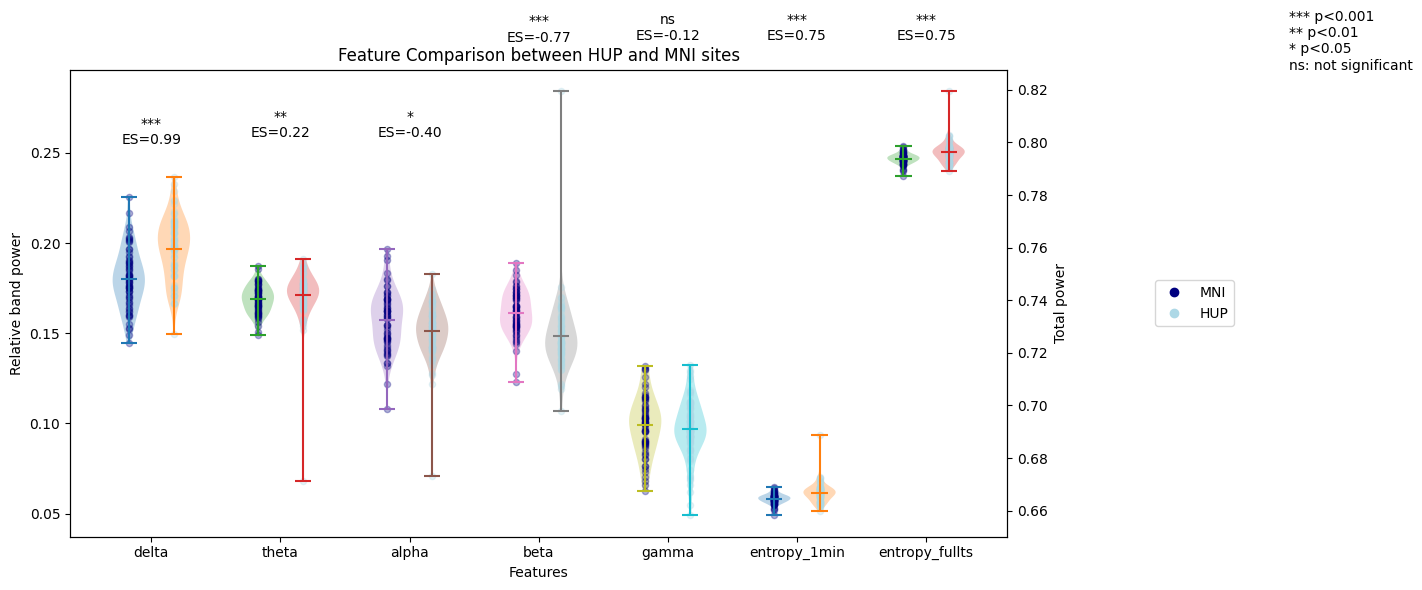

In [58]:
print_effect_sizes(hup_univar_feats_reg, mni_univar_feats_reg)
plot_feature_comparison(hup_univar_feats_reg, mni_univar_feats_reg, global_results)

CHECKING FOR OUTLIERS (GLOBAL COMPARISON)

In [41]:
def detect_outliers(hup_univar_feats_reg, mni_univar_feats_reg):
    """
    Detect outliers using multiple methods
    """
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        print(f"\nAnalyzing outliers for {feature}")
        
        # 1. IQR method
        def get_iqr_outliers(data):
            Q1 = np.percentile(data, 25)
            Q3 = np.percentile(data, 75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            return outliers
        
        hup_outliers_iqr = get_iqr_outliers(hup_univar_feats_reg[feature])
        mni_outliers_iqr = get_iqr_outliers(mni_univar_feats_reg[feature])
        
        # 2. Z-score method
        def get_zscore_outliers(data, threshold=3):
            z_scores = np.abs(stats.zscore(data))
            outliers = data[z_scores > threshold]
            return outliers
        
        hup_outliers_z = get_zscore_outliers(hup_univar_feats_reg[feature])
        mni_outliers_z = get_zscore_outliers(mni_univar_feats_reg[feature])
        
        print(f"HUP IQR outliers: {len(hup_outliers_iqr)}")
        print(f"MNI IQR outliers: {len(mni_outliers_iqr)}")
        print(f"HUP Z-score outliers: {len(hup_outliers_z)}")
        print(f"MNI Z-score outliers: {len(mni_outliers_z)}")
        
        # Visualize with boxplot
        plt.figure(figsize=(8,4))
        plt.boxplot([hup_univar_feats_reg[feature], mni_univar_feats_reg[feature]], 
                   tick_labels=['HUP', 'MNI'])
        plt.title(f'{feature}')
        plt.show()

# Robust statistical comparison
def compare_sites_robustly(hup_univar_feats_reg, mni_univar_feats_reg):
    """
    Perform robust statistical comparisons
    """
    results = []
    
    for feature in hup_univar_feats_reg.filter(like='mean').columns:
        hup_data = hup_univar_feats_reg[feature]
        mni_data = mni_univar_feats_reg[feature]
        
        # 1. Robust t-test (Yuen's test)
                
        # 2. Non-parametric test (already using Mann-Whitney U)
        stat_mw, p_val_mw = stats.mannwhitneyu(hup_data, mni_data, alternative='two-sided')
        
        # 3. Robust effect size (Cliff's Delta)
        def cliffs_delta(x, y):
            nx = len(x)
            ny = len(y)
            delta = 0
            for i in x:
                for j in y:
                    if i > j:
                        delta += 1
                    elif i < j:
                        delta -= 1
            delta = delta / (nx * ny)
            return delta
        
        effect_size = cliffs_delta(hup_data, mni_data)
        
        results.append({
            'feature': feature,
            'mannwhitney_stat': stat_mw,
            'mannwhitney_p': p_val_mw,
            'cliffs_delta': effect_size
        })
    
    return pd.DataFrame(results)


Analyzing outliers for deltaRel_mean
HUP IQR outliers: 0
MNI IQR outliers: 1
HUP Z-score outliers: 0
MNI Z-score outliers: 0


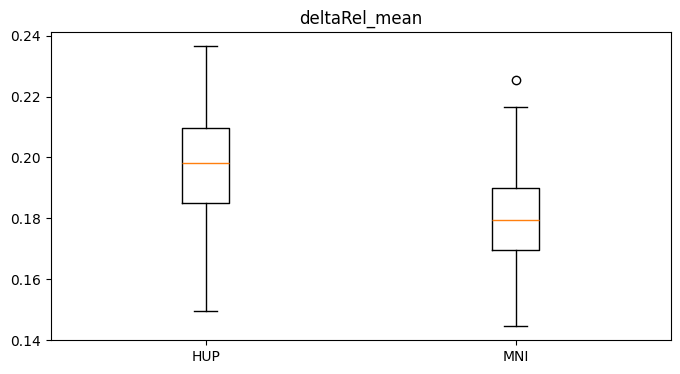


Analyzing outliers for thetaRel_mean
HUP IQR outliers: 2
MNI IQR outliers: 0
HUP Z-score outliers: 1
MNI Z-score outliers: 0


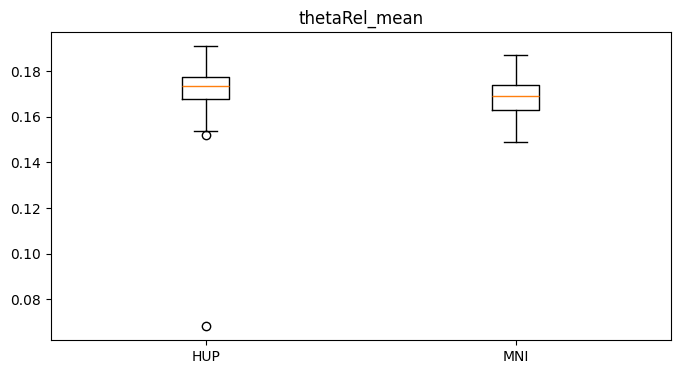


Analyzing outliers for alphaRel_mean
HUP IQR outliers: 1
MNI IQR outliers: 1
HUP Z-score outliers: 1
MNI Z-score outliers: 1


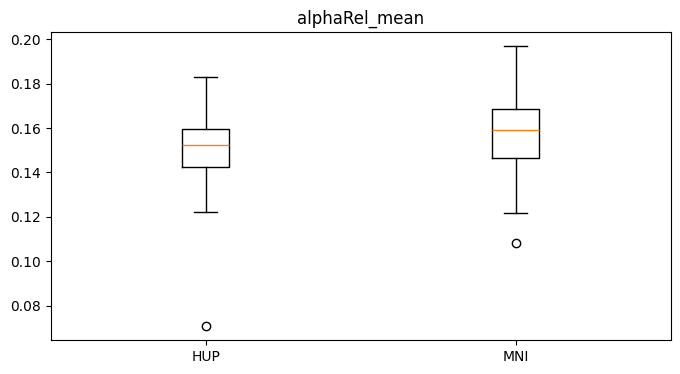


Analyzing outliers for betaRel_mean
HUP IQR outliers: 2
MNI IQR outliers: 2
HUP Z-score outliers: 1
MNI Z-score outliers: 1


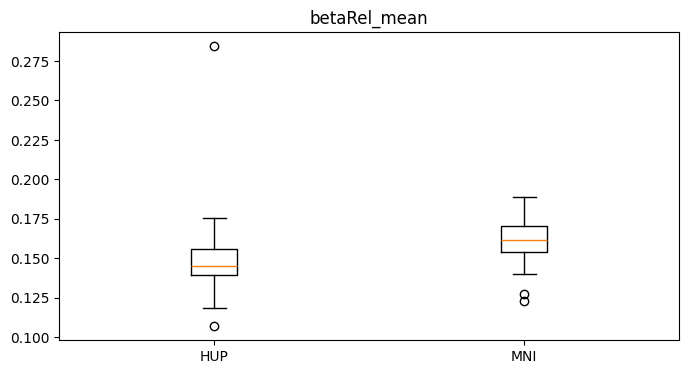


Analyzing outliers for gammaRel_mean
HUP IQR outliers: 3
MNI IQR outliers: 0
HUP Z-score outliers: 0
MNI Z-score outliers: 0


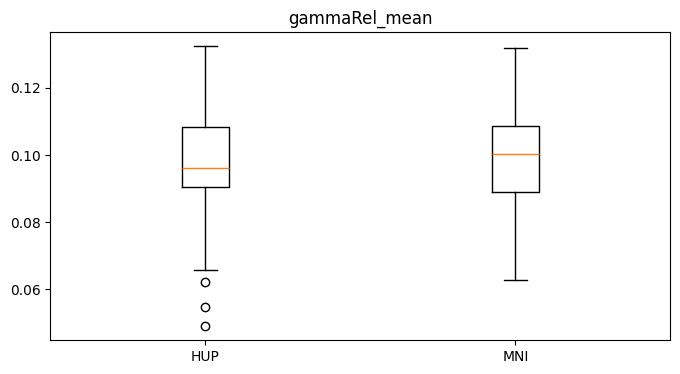


Analyzing outliers for entropy_1min_mean
HUP IQR outliers: 1
MNI IQR outliers: 5
HUP Z-score outliers: 1
MNI Z-score outliers: 1


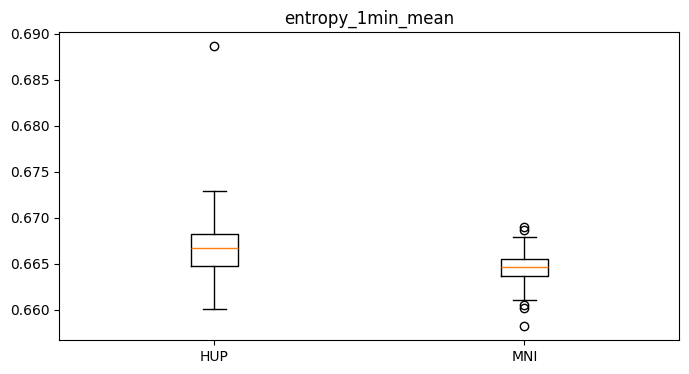


Analyzing outliers for entropy_fullts_mean
HUP IQR outliers: 1
MNI IQR outliers: 5
HUP Z-score outliers: 1
MNI Z-score outliers: 1


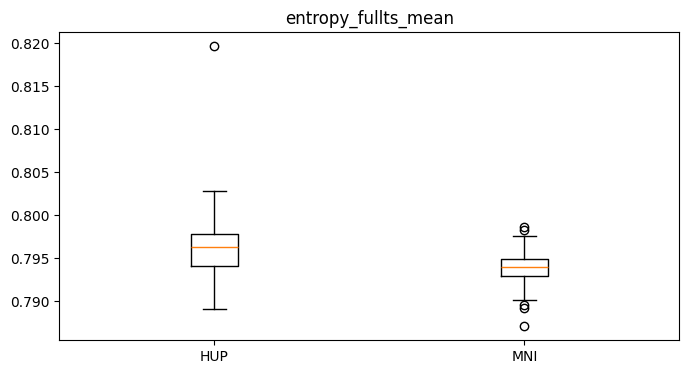

In [42]:
detect_outliers(hup_univar_feats_reg, mni_univar_feats_reg)
robust_results = compare_sites_robustly(hup_univar_feats_reg, mni_univar_feats_reg)